In [1]:
import pandas as pd

In [2]:
transfusion = pd.read_csv("transfusion.data")
transfusion.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [3]:
print(transfusion.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB
None


## 2. Loading the blood donations data
<p>We now know that we are working with a typical CSV file (i.e., the delimiter is <code>,</code>, etc.). We proceed to loading the data into memory.</p>

In [4]:

#print(transfusion.iloc[:1])
print(transfusion.head(2))

   Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)  \
0                 2                 50                  12500             98   
1                 0                 13                   3250             28   

   whether he/she donated blood in March 2007  
0                                           1  
1                                           1  


In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Rename target column as 'target'
transfusion.rename(
    columns={'whether he/she donated blood in March 2007': 'target'},
    inplace=True)

# Print out the first 2 rows
transfusion.head(2)
# ... YOUR CODE FOR TASK 4 ...
#print(transfusion.iloc[:2])

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
0,2,50,12500,98,1
1,0,13,3250,28,1


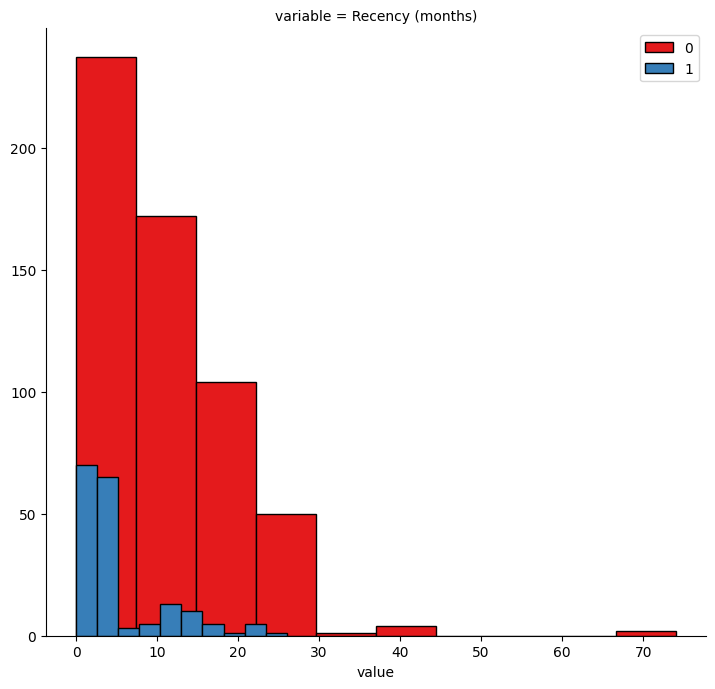

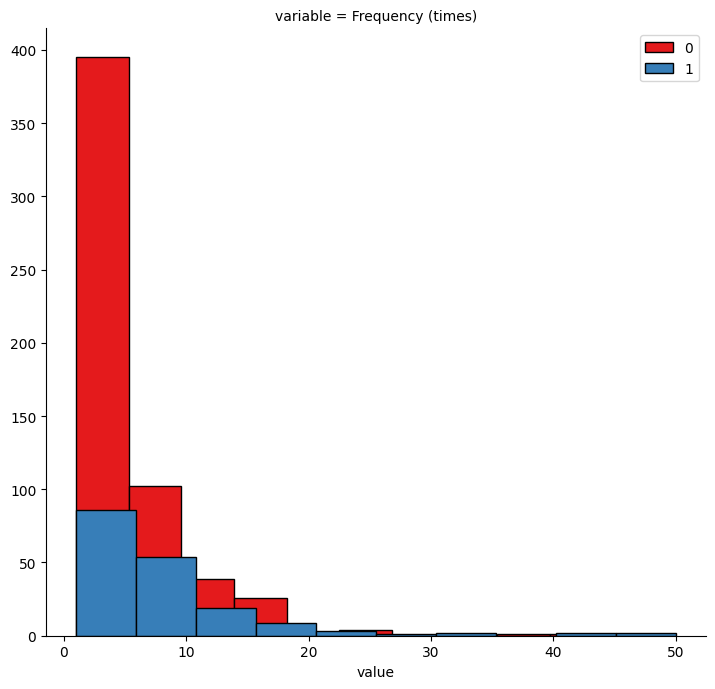

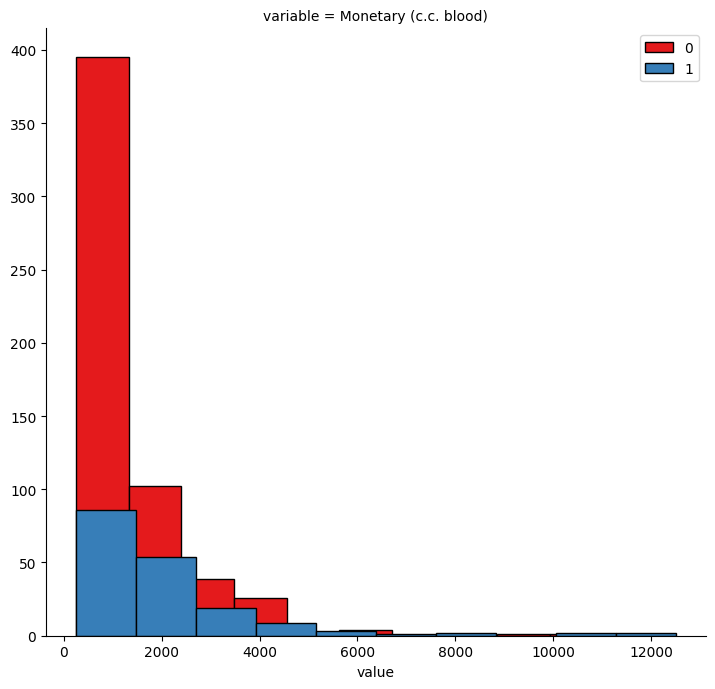

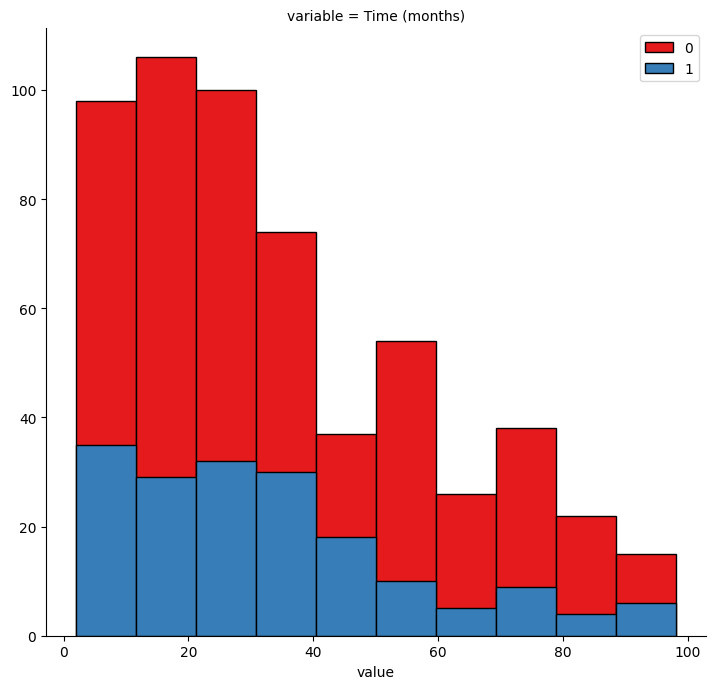

In [6]:
# Print a concise summary of transfusion DataFrame
# ... YOUR CODE FOR TASK 3 ...
for col in transfusion.drop(columns='target').columns:
    df = pd.melt(transfusion[[col,'target']], id_vars='target', value_vars=col, value_name='value')
    g = sns.FacetGrid(df,col="variable", hue="target", palette="Set1", col_wrap=2, height = 7)
    g.map(plt.hist, 'value', bins =10,ec="k")
    g.axes[-1].legend()

In [7]:
# Print target incidence proportions, rounding output to 3 decimal places
# ... YOUR CODE FOR TASK 5 ...
transfusion.isnull().sum()

Recency (months)         0
Frequency (times)        0
Monetary (c.c. blood)    0
Time (months)            0
target                   0
dtype: int64

In [8]:
# Print target incidence proportions, rounding output to 3 decimal places
transfusion['target'].value_counts(normalize=True).round(3)

target
0    0.762
1    0.238
Name: proportion, dtype: float64

In [9]:
# Import train_test_split method
from sklearn.model_selection import train_test_split

# Split transfusion DataFrame into
# X_train, X_test, y_train and y_test datasets,
# stratifying on the `target` column
X_train, X_test, y_train, y_test = train_test_split(
    transfusion.drop(columns='target'),
    transfusion.target,
    test_size=0.25,
    random_state=42,
    stratify=transfusion[['target']])

In [10]:
# Print out the first 2 rows of X_train
# ... YOUR CODE FOR TASK 6 ...
X_train.shape

(561, 4)

In [11]:
!pip install tpot

In [12]:
# Import TPOTClassifier and roc_auc_score
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light')
tpot.fit(X_train, y_train)

                                                                             
Generation 1 - Current best internal CV score: 0.7422459184429089
                                                                             
Generation 2 - Current best internal CV score: 0.7422459184429089
                                                                             
Generation 3 - Current best internal CV score: 0.7423330644124078
                                                                              
Generation 4 - Current best internal CV score: 0.7423330644124078
                                                                              
Generation 5 - Current best internal CV score: 0.7423330644124078
                                                                              
Best pipeline: LogisticRegression(RobustScaler(input_matrix), C=25.0, dual=False, penalty=l2)


TPOTClassifier(config_dict='TPOT light', disable_update_check=True,
               generations=5, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

In [13]:
# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')


AUC score: 0.7858


In [14]:
# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')


Best pipeline steps:
1. RobustScaler()
2. LogisticRegression(C=25.0, random_state=42)


In [15]:
# X_train's variance, rounding the output to 3 decimal places
# ... YOUR CODE FOR TASK 8 ...
X_train.var().round(3)

Recency (months)              66.929
Frequency (times)             33.830
Monetary (c.c. blood)    2114363.700
Time (months)                611.147
dtype: float64

In [16]:
# Import numpy
import numpy as np

# Copy X_train and X_test into X_train_normed and X_test_normed
X_train_normed, X_test_normed = X_train.copy(), X_test.copy()

# Specify which column to normalize
col_to_normalize = 'Monetary (c.c. blood)'

# Log normalization
for df_ in [X_train_normed, X_test_normed]:
    # Add log normalized column
    df_['monetary_log'] = np.log(df_[col_to_normalize])
    # Drop the original column
    df_.drop(columns=col_to_normalize, inplace=True)

# Check the variance for X_train_normed
# ... YOUR CODE FOR TASK 9 ...
X_train_normed.var().round(3)

Recency (months)      66.929
Frequency (times)     33.830
Time (months)        611.147
monetary_log           0.837
dtype: float64

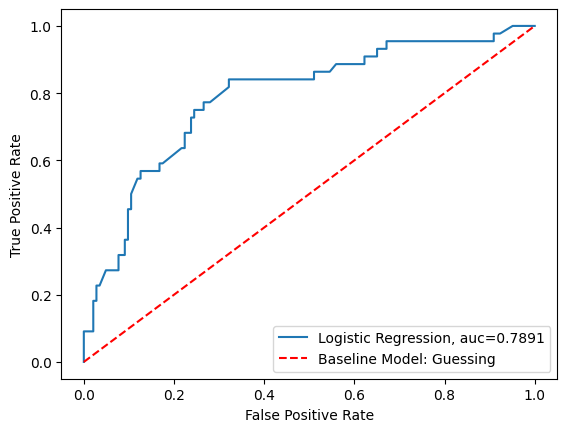


AUC score: 0.7891

Log Loss: 0.4476


In [17]:
# Importing modules
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import log_loss

# Instantiate LogisticRegression
logreg = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)

# Train the model
logreg.fit(X_train_normed, y_train)
y_pred = logreg.predict(X_test_normed)

# AUC score for tpot model
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test_normed)[:, 1])
y_pred_proba = logreg.predict_proba(X_test_normed)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc.round(4)))
plt.plot([0, 1], [0, 1],'r--', label = 'Baseline Model: Guessing')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print(f'\nAUC score: {logreg_auc_score:.4f}')
print(f'\nLog Loss: {log_loss(y_test, logreg.predict_proba(X_test_normed)[:, 1]):.4f}')

Accuracy: 0.7754010695187166
Precision: 0.625
Recall: 0.11363636363636363


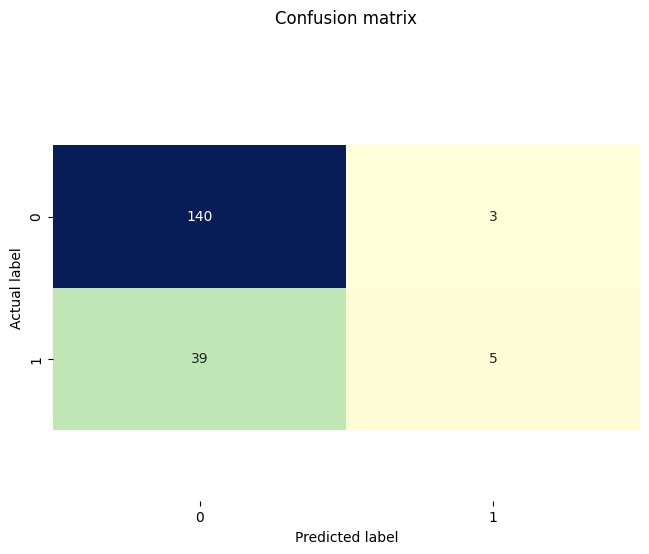

In [18]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes

# HEATMAP
ax = sns.heatmap(cnf_matrix, annot = True ,  cmap="YlGnBu",  fmt ='d', cbar = False)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [19]:
# Importing itemgetter
from operator import itemgetter

# Sort models based on their AUC score from highest to lowest
sorted(
    [('tpot', tpot_auc_score), ('logreg', logreg_auc_score)],
    key=itemgetter(1),
    reverse=True)

[('logreg', 0.7890972663699937), ('tpot', 0.7857596948506039)]